In [2]:
import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [66]:
twitter_data = pd.read_csv("Twitter_Data_1.csv")
df_twitter = twitter_data.copy()

In [67]:
df_twitter.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


<Axes: xlabel='category'>

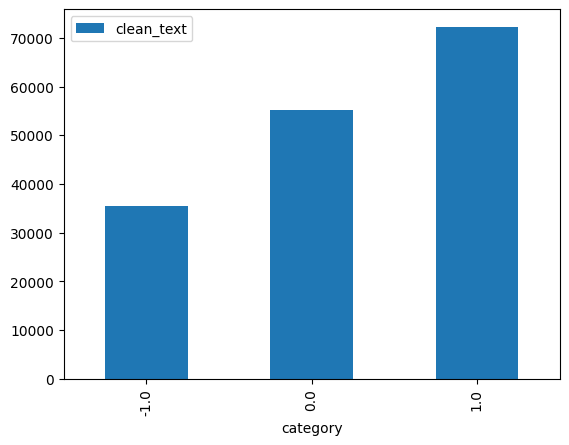

In [68]:
df_twitter.groupby('category').count().plot(kind='bar')

In [45]:
tweets = df_twitter['clean_text'].astype(str).tolist()
classes = df_twitter['category'].astype(float).tolist()

In [46]:
new_classes = []
for i in classes:
    if i == 0.0:
        new_classes.append(0)
    elif i == 1.0:
        new_classes.append(1)
    else:
        new_classes.append(-1)

In [47]:
from nltk.stem import WordNetLemmatizer

In [48]:
def Preprocessing(data):
    lemmatizer = WordNetLemmatizer()
    data = re.sub(r"http\S+", "", data).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords_set = set(stopwords.words('english'))
    words = word_tokenize(data)
    words = [word for word in words if word not in stopwords_set]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [49]:
print(tweets[0])

when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples


In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [50]:
tweets = [Preprocessing(' '.join((i.split()[:35]))) for i in tweets]

In [51]:
print(tweets[0])

modi promised “ minimum government maximum governance ” expected begin difficult job reforming state take year get justice state business exit psus temple


In [52]:
vectorizer = CountVectorizer(analyzer="word", max_features=3000, dtype=np.float32)

In [53]:
freq_tweets_train = vectorizer.fit_transform(tweets)

In [54]:
from keras.utils import to_categorical

In [55]:
num_classes = 3
y = np.array(new_classes,dtype = np.float32)

In [56]:
y_labels_encoded = to_categorical(new_classes, num_classes)

In [57]:
X = freq_tweets_train.toarray()

In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_labels_encoded, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [59]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, LSTM, Dense, GlobalMaxPooling1D, MaxPooling1D,MaxPooling1D, Dropout, Reshape, Bidirectional
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [60]:
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=X_train.shape[1], output_dim=128, input_length=X_train.shape[1]))
model.add(Conv1D(128, 5, activation=LeakyReLU(alpha=0.1)))
model.add(GlobalMaxPooling1D())
model.add(Reshape((1, -1)))  # Add a Reshape layer to transform the 2D tensor to 3D
model.add(LSTM(64))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


In [61]:
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1,callbacks=[early_stopping])

Epoch 1/10
1783/1783 [==============================] - 84s 46ms/step - loss: 1.0657 - accuracy: 0.4618 - val_loss: 1.0351 - val_accuracy: 0.4757
Epoch 2/10
1783/1783 [==============================] - 78s 44ms/step - loss: 1.0365 - accuracy: 0.4700 - val_loss: 1.0341 - val_accuracy: 0.4756
Epoch 3/10
1783/1783 [==============================] - 78s 44ms/step - loss: 1.0358 - accuracy: 0.4683 - val_loss: 1.0343 - val_accuracy: 0.4756
Epoch 4/10
1783/1783 [==============================] - 78s 44ms/step - loss: 1.0355 - accuracy: 0.4698 - val_loss: 1.0334 - val_accuracy: 0.4756
Epoch 5/10
1783/1783 [==============================] - 78s 44ms/step - loss: 1.0354 - accuracy: 0.4695 - val_loss: 1.0336 - val_accuracy: 0.4756
Epoch 6/10
1783/1783 [==============================] - 78s 44ms/step - loss: 1.0351 - accuracy: 0.4701 - val_loss: 1.0345 - val_accuracy: 0.4756
Epoch 7/10
1783/1783 [==============================] - 78s 44ms/step - loss: 1.0351 - accuracy: 0.4685 - val_loss: 1.0338 -

In [64]:
model.save("cnnlstm.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

764/764 [==============================] - 7s 9ms/step - loss: 1.0346 - accuracy: 0.4719
Test loss: 1.0346, Test accuracy: 0.4719


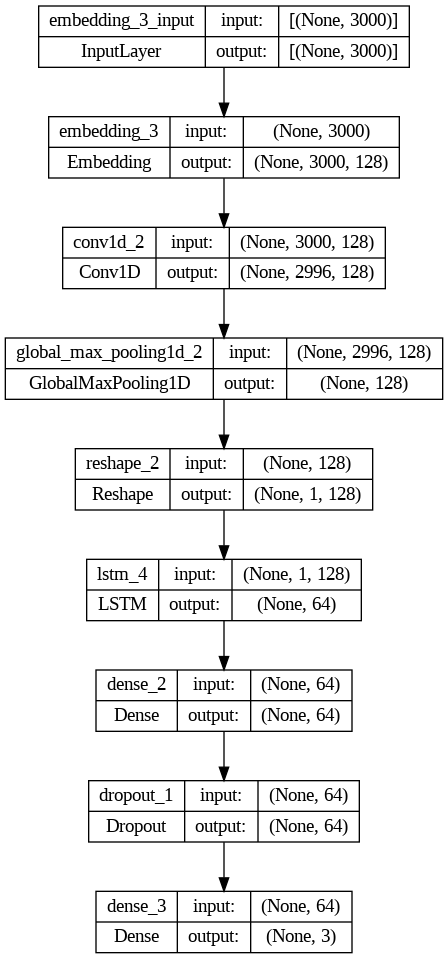

In [63]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

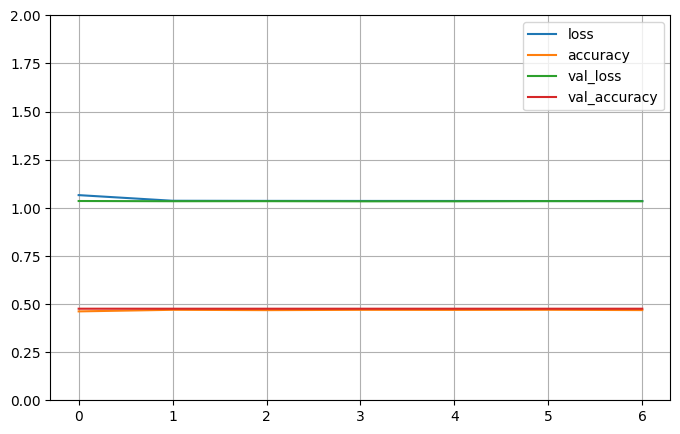

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Create the Transform
vectorizer = CountVectorizer()

In [74]:
tweets2 = df_twitter['clean_text'].astype(str).tolist()

In [75]:
num_classes = 3
y = np.array(new_classes,dtype = np.float32)
print(y)

[-1.  0.  1. ...  0.  0.  1.]


In [76]:
X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size=0.2, random_state=42)

In [77]:
vectorizer.fit(X_train)

CountVectorizer()

In [78]:
X_train_vector = vectorizer.transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [79]:
nb = MultinomialNB()

# Train the model
nb.fit(X_train_vector, y_train)

MultinomialNB()

In [80]:
y_pred = nb.predict(X_test_vector)

# Calculate Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.719966


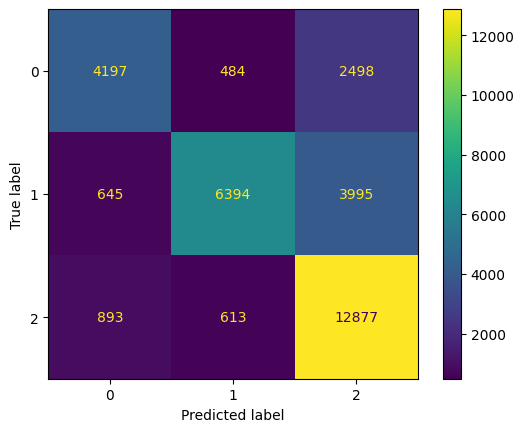

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Assuming nb is your trained MultinomialNB model and X_test, y_test are your testing data
y_pred = nb.predict(X_test_vector)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [84]:
pip install joblib

In [85]:
import joblib

# Save the model
joblib.dump(nb, 'nb_model.pkl')

# Load the model
#nb = joblib.load('nb_model.pkl')

['nb_model.pkl']